In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc,precision_recall_curve,roc_curve,confusion_matrix
import os,sys
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
np.random.seed(42)

In [2]:
def encode_peptide_AAindex(peptide):
    """Encode peptides using principal components derived from the AAindex database describing ~90% variance of all features derived from the AAindex database

    Args:
        peptide (str): peptide to encode

    Returns:
        np.array: encoded peptides
    """
    PCA_repr = pd.read_csv("../data/PCA_repr_aa.csv",index_col=0)
    encoded_peptide = []
    for aa in list(peptide):
        if aa == "-" or aa == "X":
            n_pcs = len(PCA_repr.columns)
            encoded_peptide.append([0 for _ in range(n_pcs)])
        else:
            encoded_peptide.append(list(PCA_repr.loc[aa]))
    return np.array(encoded_peptide)

def add_dumb_padding(peptide):
    if len(peptide) == 9:
        return peptide + "-"
    else:
        return peptide

def get_HLA_seqs(path_to_HLA_seqs):
    HLA_seqs = dict()
    with open(path_to_HLA_seqs,"r") as f:
        for line in f:
            line = line.split()
            HLA = line[0]
            seq = line[1]
            HLA_seqs[HLA] = seq
    return HLA_seqs


In [3]:
# Reading HLA seqs
HLA_seq_dict = get_HLA_seqs("../data/hla2paratopeTable_aligned.txt")
HLA_w_seq = [x for x in HLA_seq_dict.keys()]
path_to_dataset = "../data/filtered_data_IEDB_4_tested_len_9_10_full_HLA.csv"
dataset = pd.read_csv(path_to_dataset,index_col=0)
dataset["HLA_allele"] = [x.replace(":","") for x in dataset["HLA_allele"]]
no_HLA_seq = ["HLA-B*40:06","HLA-B*27:02","HLA-B*27:01",""]
dataset = dataset[dataset["HLA_allele"].isin(HLA_w_seq)]
dataset



,peptide,HLA_allele,immunogenicity,tested_subjects,positive_subjects
5,AAGIGILTV,HLA-A*0201,0.833333,4.0,4.0
6,AALFFFDID,HLA-A*0201,0.250000,10.0,2.0
10,AAVKAGAAL,HLA-B*0702,0.750000,2.0,2.0
25,ADVEFCLSL,HLA-B*4403,0.500000,6.0,3.0
189,AEVEEHRTV,HLA-B*4001,0.153846,11.0,1.0
...,...,...,...,...,...
27637,FTGSEVENV,HLA-A*0201,0.083333,10.0,0.0
27638,FTSHEHFGL,HLA-A*0201,0.083333,10.0,0.0
27667,MQVIGDQYV,HLA-A*0201,0.083333,10.0,0.0
27685,SQEPMSIYV,HLA-A*0201,0.083333,10.0,0.0


In [4]:
# Adding stupid padding
dataset["peptide"] = [add_dumb_padding(peptide) for peptide in dataset["peptide"]]
HLAs_seqs = [HLA_seq_dict[HLA.replace(":","")] for HLA in dataset["HLA_allele"]]
input_peptides = np.array([encode_peptide_AAindex(x) for x in dataset["peptide"]],dtype="float")
input_HLA = np.array([encode_peptide_AAindex(HLA_seq_dict[x]) for x in dataset["HLA_allele"]],dtype="float")
input_label = np.array([round(x,0) for x in dataset["immunogenicity"]])

# Reshaping to fit models
input_peptides = input_peptides.reshape(-1,1,10,12)
input_HLA = input_HLA.reshape(-1,1,46,12)
input_label = input_label.reshape(-1,1)


In [5]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d

In [6]:
input_label.shape

(5227, 1)

In [7]:

# hyperameters of the model

peptide_input_channels = input_peptides.shape[1]
peptide_input_height = input_peptides.shape[2]
peptide_input_width = input_peptides.shape[3]

hla_input_channels = input_HLA.shape[1]
hla_input_height = input_HLA.shape[2]
hla_input_width = input_HLA.shape[3]

# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Convelution of peptide
        self.conv1_peptide = Conv2d(in_channels=peptide_input_channels,
                            out_channels=16,
                            kernel_size=(2,12),
                            stride=1,
                            padding=0)
        
        self.BatchNorm_conv1_peptides = BatchNorm2d(16) # Output channels from the previous layer
        self.conv2_peptide = Conv2d(in_channels=16,
                            out_channels=32,
                            kernel_size=(2,1),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv2_peptides = BatchNorm2d(32) # Output channels from the previous layer
        self.maxpool1_peptide = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)

        # Convelution of HLA
        self.conv1_HLA = Conv2d(in_channels=peptide_input_channels,
                            out_channels=16,
                            kernel_size=(15,12),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv1_HLA = BatchNorm2d(16) # Output channels from the previous layer
        self.maxpool1_HLA = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)
        
        self.conv2_HLA = Conv2d(in_channels=16,
                            out_channels=32,
                            kernel_size=(9,1),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv2_peptides = BatchNorm2d(32) # Output channels from the previous layer
        self.maxpool2_HLA = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)

        # Denselayer
        self.l_out = Linear(in_features=256,
                            out_features=1,
                            bias=False)
        self.drop_out = nn.Dropout(p=0.2)


    def forward(self, peptide, HLA): # x.size() = [batch, channel, height, width]

        # Encoding the peptide
        peptide = self.conv1_peptide(peptide)
        peptide = self.BatchNorm_conv1_peptides(peptide)
        peptide = relu(peptide)
        peptide = self.conv2_peptide(peptide)
        peptide = self.BatchNorm_conv2_peptides(peptide)
        peptide = relu(peptide)
        peptide = self.maxpool1_peptide(peptide)
        peptide = torch.flatten(peptide,start_dim=1)

        # Encoding the HLA
        HLA = self.conv1_HLA(HLA)
        HLA = self.BatchNorm_conv1_HLA(HLA)
        HLA = relu(HLA)
        HLA = self.maxpool1_HLA(HLA)
        HLA = self.conv2_HLA(HLA)
        HLA = self.BatchNorm_conv2_peptides(HLA)
        HLA = relu(HLA)
        HLA = self.maxpool2_HLA(HLA)
        HLA = torch.flatten(HLA,start_dim=1)


        # Combining the output
        combined_input = torch.cat((peptide, HLA), 1)
        x = self.l_out(combined_input)
        x = self.drop_out(x)
        x = nn.Sigmoid()(x)
        return x

net = Net()
print(net)

Net(
  (conv1_peptide): Conv2d(1, 16, kernel_size=(2, 12), stride=(1, 1))
  (BatchNorm_conv1_peptides): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_peptide): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1))
  (BatchNorm_conv2_peptides): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1_peptide): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv1_HLA): Conv2d(1, 16, kernel_size=(15, 12), stride=(1, 1))
  (BatchNorm_conv1_HLA): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1_HLA): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2_HLA): Conv2d(16, 32, kernel_size=(9, 1), stride=(1, 1))
  (maxpool2_HLA): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (l_out): Linear(in_features=256, out_features=1, bias=False)
  (drop_out): Dropout(p=0

In [8]:
peptide_random = np.random.normal(0,1, (128, 1, 10, 12)).astype('float32')
peptide_random = Variable(torch.from_numpy(peptide_random))
HLA_random = np.random.normal(0,1, (128, 1, 46, 12)).astype('float32')
HLA_random = Variable(torch.from_numpy(HLA_random))
output = net(peptide_random,HLA_random)

In [9]:
import random
random.seed(10)
input1 = input_peptides.astype('float32')
input2 = input_HLA.astype('float32')
label = input_label.astype('float32')

array = np.arange(len(dataset))
train_index = np.random.choice(array,int(len(dataset)*0.9),replace=False)
valid_index = [item for item in array if item not in train_index]


In [10]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.00001)

In [11]:
input1 = input1.astype('float32')
input2 = input2.astype('float32')
label = label.astype('float32')
batch_size = 16
epochs = 100

peptide_train, peptide_val = input1[train_index], input1[valid_index]
HLA_train, HLA_val = input2[train_index], input2[valid_index]
label_train, label_val = label[train_index], label[valid_index]

peptide_train_loader = list(DataLoader(peptide_train,batch_size=batch_size))
HLA_train_loader = list(DataLoader(HLA_train,batch_size=batch_size))
label_train_loader = list(DataLoader(label_train,batch_size=batch_size))

peptide_val_loader = list(DataLoader(peptide_val,batch_size=batch_size))
HLA_val_loader = list(DataLoader(HLA_val,batch_size=batch_size))
label_val_loader = list(DataLoader(label_val,batch_size=batch_size))

losses = []
cur_loss = 0

train_acc = []
valid_acc = []

train_prediction_pr_epoch = []
train_labels_pr_epoch = []

valid_prediction_pr_epoch = []
valid_labels_pr_epoch = []

for epoch in range(epochs):
    ## Firstly the model is trained
    cur_loss = 0
    net.train()
    for i in range(len(peptide_train_loader)):
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(peptide_train_loader[i],HLA_train_loader[i])
        batch_loss = criterion(outputs, label_train_loader[i])
        batch_loss.backward()
        optimizer.step()
        cur_loss += batch_loss
    losses.append(cur_loss / batch_size)


    ## The model is then evalauted on both the training and valdition dataset
    net.eval()
    train_preds, train_targs = [], []
    train_preds_labels = []
    val_preds, val_targs = [], []
    val_preds_labels = []
    for j in range(len(peptide_train_loader)):
        output = net(peptide_train_loader[j],HLA_train_loader[j])
        train_targs += list(label_train_loader[j].numpy())
        train_preds += list(output.data.numpy())
        train_preds_labels += [np.array([round(x[0],0)],dtype='float32') for x in output.data.numpy()]

    
    for k in range(len(peptide_val_loader)):
        output = net(peptide_val_loader[k],HLA_val_loader[k])
        val_targs += list(label_val_loader[k].numpy())
        val_preds_labels += [np.array([round(x[0],0)],dtype='float32') for x in output.data.numpy()]
        val_preds += list(output.data.numpy())
    
    train_acc_cur = accuracy_score(train_targs, train_preds_labels)
    valid_acc_cur = accuracy_score(val_targs, val_preds_labels)


    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)

    train_prediction_pr_epoch.append(train_preds)
    train_labels_pr_epoch.append(train_targs)

    valid_prediction_pr_epoch.append(val_preds)
    valid_labels_pr_epoch.append(val_targs)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))


Epoch  1 : Train Loss 3.209397 , Train acc 0.857781, Valid acc 0.852772
Epoch 11 : Train Loss 2.477069 , Train acc 0.858631, Valid acc 0.854685
Epoch 21 : Train Loss 2.549136 , Train acc 0.863520, Valid acc 0.858509
Epoch 31 : Train Loss 2.482326 , Train acc 0.863520, Valid acc 0.858509
Epoch 41 : Train Loss 2.475568 , Train acc 0.863520, Valid acc 0.858509
Epoch 51 : Train Loss 2.483138 , Train acc 0.863733, Valid acc 0.858509
Epoch 61 : Train Loss 2.511465 , Train acc 0.863946, Valid acc 0.858509
Epoch 71 : Train Loss 2.397505 , Train acc 0.864371, Valid acc 0.858509
Epoch 81 : Train Loss 2.476410 , Train acc 0.864796, Valid acc 0.860421
Epoch 91 : Train Loss 2.385092 , Train acc 0.864583, Valid acc 0.858509


(Text(0.5, 0, 'epochs'), Text(0, 0.5, 'Acc'))

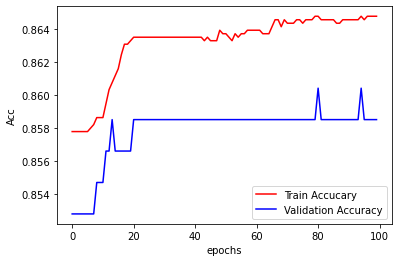

In [12]:
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('epochs'), plt.ylabel('Acc')

In [17]:
val_predictions = np.array(valid_prediction_pr_epoch)
val_labels = np.array(valid_labels_pr_epoch)


val_predictions = val_predictions.reshape(val_predictions.shape[0],val_predictions.shape[1])
val_labels = val_labels.reshape(val_labels.shape[0],val_labels.shape[1])

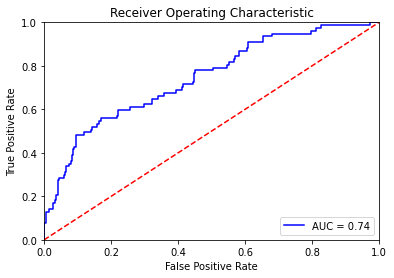

In [18]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

best_epoch_model = np.argmax(valid_acc)
fpr, tpr, threshold = metrics.roc_curve(val_labels[best_epoch_model],val_predictions[best_epoch_model])
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

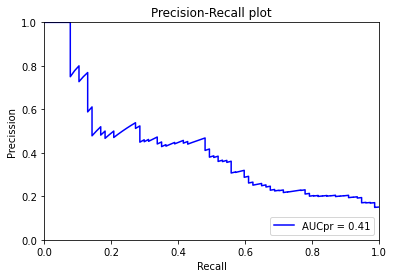

In [19]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(val_labels[best_epoch_model],val_predictions[best_epoch_model])
roc_auc = metrics.auc(recall, precision)
plt.title('Precision-Recall plot')
plt.plot(recall, precision, 'b', label = 'AUCpr = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precission')
plt.xlabel('Recall')
plt.show()


In [22]:
unqiue,count = np.unique(val_labels[best_epoch_model],return_counts=True)

In [23]:
count

array([446,  77])

In [24]:
unqiue

array([0., 1.], dtype=float32)